# Option 2: Voxelwise Selectivity Tracking
Track selectivity of individual voxels across sessions
Test if bilateral categories (object/house) show more spatial stability than unilateral (face/word)

In [1]:
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
from nilearn import plotting

BASE_DIR = Path('/user_data/csimmon2/long_pt')

SUBJECTS = {
    'sub-004': {'code': 'UD', 'sessions': ['01', '02', '03', '05', '06'], 'hemi': 'left'},
    'sub-007': {'code': 'OT', 'sessions': ['01', '03', '04'], 'hemi': 'left'},
    'sub-021': {'code': 'TC', 'sessions': ['01', '02', '03'], 'hemi': 'right'}
}

print("Setup complete")

Setup complete


In [2]:
# STEP 1: Load VOTC mask and extract voxel coordinates

def load_votc_voxels(subject_id):
    """Get all voxel coordinates in VOTC mask"""
    hemi = SUBJECTS[subject_id]['hemi']
    hemi_prefix = 'l' if hemi == 'left' else 'r'
    
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi_prefix}_VOTC_FG_OTS_mask.nii.gz'
    roi_img = nib.load(roi_file)
    roi_data = roi_img.get_fdata()
    
    # Get voxel indices
    voxel_indices = np.where(roi_data > 0)
    n_voxels = len(voxel_indices[0])
    
    # Convert to world coordinates
    voxel_coords = np.column_stack(voxel_indices)
    world_coords = nib.affines.apply_affine(roi_img.affine, voxel_coords)
    
    return {
        'voxel_indices': voxel_indices,
        'world_coords': world_coords,
        'n_voxels': n_voxels,
        'reference': roi_img
    }

# Load for all subjects
votc_voxels = {}
for subject_id in SUBJECTS.keys():
    votc_voxels[subject_id] = load_votc_voxels(subject_id)
    print(f"{subject_id}: {votc_voxels[subject_id]['n_voxels']} voxels")

sub-004: 52114 voxels
sub-007: 61785 voxels
sub-021: 20403 voxels


In [3]:
# STEP 2: Extract selectivity for each voxel across sessions

def extract_voxel_selectivity(subject_id, session, contrast, voxel_info):
    """Extract selectivity values for all voxels in one session"""
    
    # Map contrast to cope number
    cope_map = {'face_word': 13, 'object_house': 14}
    cope_num = cope_map[contrast]
    
    # Load zstat from HighLevel
    zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
    
    if not zstat_file.exists():
        return None
    
    zstat_img = nib.load(zstat_file)
    zstat_data = zstat_img.get_fdata()
    
    # Extract values at voxel locations
    voxel_values = zstat_data[voxel_info['voxel_indices']]
    
    return voxel_values

# Extract for all subjects, sessions, contrasts
voxel_timeseries = {}

for subject_id in SUBJECTS.keys():
    print(f"\nExtracting {subject_id}...")
    voxel_timeseries[subject_id] = {}
    
    for contrast in ['face_word', 'object_house']:
        voxel_timeseries[subject_id][contrast] = {}
        
        for session in SUBJECTS[subject_id]['sessions']:
            values = extract_voxel_selectivity(subject_id, session, contrast, votc_voxels[subject_id])
            
            if values is not None:
                voxel_timeseries[subject_id][contrast][session] = values
                print(f"  {contrast} ses-{session}: mean={values.mean():.2f}")

print("\nExtraction complete!")


Extracting sub-004...
  face_word ses-01: mean=0.74
  face_word ses-02: mean=-0.26
  face_word ses-03: mean=0.04
  face_word ses-05: mean=1.47
  face_word ses-06: mean=0.76
  object_house ses-01: mean=-0.33
  object_house ses-02: mean=0.69
  object_house ses-03: mean=1.03
  object_house ses-05: mean=1.35
  object_house ses-06: mean=-0.57

Extracting sub-007...
  face_word ses-01: mean=2.62
  face_word ses-03: mean=1.42
  face_word ses-04: mean=1.16
  object_house ses-01: mean=2.28
  object_house ses-03: mean=1.81
  object_house ses-04: mean=1.55

Extracting sub-021...
  face_word ses-01: mean=0.84
  face_word ses-02: mean=0.70
  face_word ses-03: mean=-0.83
  object_house ses-01: mean=-0.15
  object_house ses-02: mean=-0.46
  object_house ses-03: mean=-0.21

Extraction complete!


In [4]:
# STEP 3: Analyze spatial stability - find peaks in ses-01, track movement

def find_selectivity_peaks(selectivity_values, world_coords, threshold_percentile=95):
    """Find top voxels and their locations"""
    threshold = np.percentile(selectivity_values, threshold_percentile)
    top_voxels = selectivity_values > threshold
    
    if np.sum(top_voxels) == 0:
        return None
    
    peak_idx = np.argmax(selectivity_values)
    peak_location = world_coords[peak_idx]
    peak_value = selectivity_values[peak_idx]
    
    # Center of mass of top voxels
    top_coords = world_coords[top_voxels]
    center_of_mass = np.mean(top_coords, axis=0)
    
    return {
        'peak_location': peak_location,
        'peak_value': peak_value,
        'center_of_mass': center_of_mass,
        'n_top_voxels': np.sum(top_voxels)
    }

# Track peaks across sessions
peak_tracking = {}

for subject_id in SUBJECTS.keys():
    print(f"\n{SUBJECTS[subject_id]['code']} ({subject_id}):")
    peak_tracking[subject_id] = {}
    
    for contrast in ['face_word', 'object_house']:
        print(f"\n  {contrast}:")
        peak_tracking[subject_id][contrast] = {}
        
        sessions = SUBJECTS[subject_id]['sessions']
        
        for session in sessions:
            if session not in voxel_timeseries[subject_id][contrast]:
                continue
            
            values = voxel_timeseries[subject_id][contrast][session]
            coords = votc_voxels[subject_id]['world_coords']
            
            peaks = find_selectivity_peaks(values, coords)
            
            if peaks:
                peak_tracking[subject_id][contrast][session] = peaks
                print(f"    ses-{session}: peak at ({peaks['peak_location'][0]:.1f}, "
                      f"{peaks['peak_location'][1]:.1f}, {peaks['peak_location'][2]:.1f}), "
                      f"z={peaks['peak_value']:.2f}")

print("\nPeak tracking complete!")


UD (sub-004):

  face_word:
    ses-01: peak at (36.5, -70.0, -2.0), z=4.22
    ses-02: peak at (36.5, -59.0, 3.0), z=3.86
    ses-03: peak at (18.5, -82.0, -6.0), z=3.16
    ses-05: peak at (43.5, -62.0, 5.0), z=5.45
    ses-06: peak at (42.5, -68.0, 0.0), z=4.70

  object_house:
    ses-01: peak at (22.5, -75.0, -7.0), z=2.97
    ses-02: peak at (31.5, -37.0, 12.0), z=4.22
    ses-03: peak at (23.5, -77.0, 5.0), z=5.14
    ses-05: peak at (55.5, -69.0, 3.0), z=6.01
    ses-06: peak at (34.5, -23.0, -1.0), z=3.08

OT (sub-007):

  face_word:
    ses-01: peak at (27.5, -76.0, -1.0), z=14.23
    ses-03: peak at (24.5, -80.0, -8.0), z=10.37
    ses-04: peak at (17.5, -100.0, 14.0), z=8.77

  object_house:
    ses-01: peak at (29.5, -73.0, 0.0), z=14.73
    ses-03: peak at (24.5, -77.0, -6.0), z=10.86
    ses-04: peak at (17.5, -99.0, 15.0), z=9.30

TC (sub-021):

  face_word:
    ses-01: peak at (33.5, -57.0, 3.0), z=9.79
    ses-02: peak at (33.5, -53.0, 6.0), z=5.87
    ses-03: peak a

In [5]:
# STEP 4: Calculate peak displacement (spatial stability metric)

def calculate_peak_displacement(peak_dict):
    """Calculate displacement of peaks from ses-01"""
    sessions = sorted(peak_dict.keys())
    
    if '01' not in sessions or len(sessions) < 2:
        return None
    
    baseline_peak = peak_dict['01']['peak_location']
    
    displacements = []
    for ses in sessions[1:]:
        current_peak = peak_dict[ses]['peak_location']
        distance = np.sqrt(np.sum((current_peak - baseline_peak)**2))
        displacements.append({'session': ses, 'distance_mm': distance})
    
    return displacements

# Calculate for all subjects
spatial_stability = {}

print("Peak displacement from ses-01:")
print("=" * 60)

for subject_id in SUBJECTS.keys():
    print(f"\n{SUBJECTS[subject_id]['code']} ({subject_id}):")
    spatial_stability[subject_id] = {}
    
    for contrast in ['face_word', 'object_house']:
        displacements = calculate_peak_displacement(peak_tracking[subject_id][contrast])
        
        if displacements:
            spatial_stability[subject_id][contrast] = displacements
            print(f"  {contrast}:")
            for disp in displacements:
                print(f"    ses-{disp['session']}: {disp['distance_mm']:.2f} mm")
            
            mean_disp = np.mean([d['distance_mm'] for d in displacements])
            print(f"    Mean displacement: {mean_disp:.2f} mm")

Peak displacement from ses-01:

UD (sub-004):
  face_word:
    ses-02: 12.08 mm
    ses-03: 22.00 mm
    ses-05: 12.73 mm
    ses-06: 6.63 mm
    Mean displacement: 13.36 mm
  object_house:
    ses-02: 43.43 mm
    ses-03: 12.21 mm
    ses-05: 35.00 mm
    ses-06: 53.70 mm
    Mean displacement: 36.08 mm

OT (sub-007):
  face_word:
    ses-03: 8.60 mm
    ses-04: 30.02 mm
    Mean displacement: 19.31 mm
  object_house:
    ses-03: 8.77 mm
    ses-04: 32.33 mm
    Mean displacement: 20.55 mm

TC (sub-021):
  face_word:
    ses-02: 5.00 mm
    ses-03: 17.58 mm
    Mean displacement: 11.29 mm
  object_house:
    ses-02: 21.19 mm
    ses-03: 20.69 mm
    Mean displacement: 20.94 mm


/tmp/ipykernel_3086375/1938450859.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


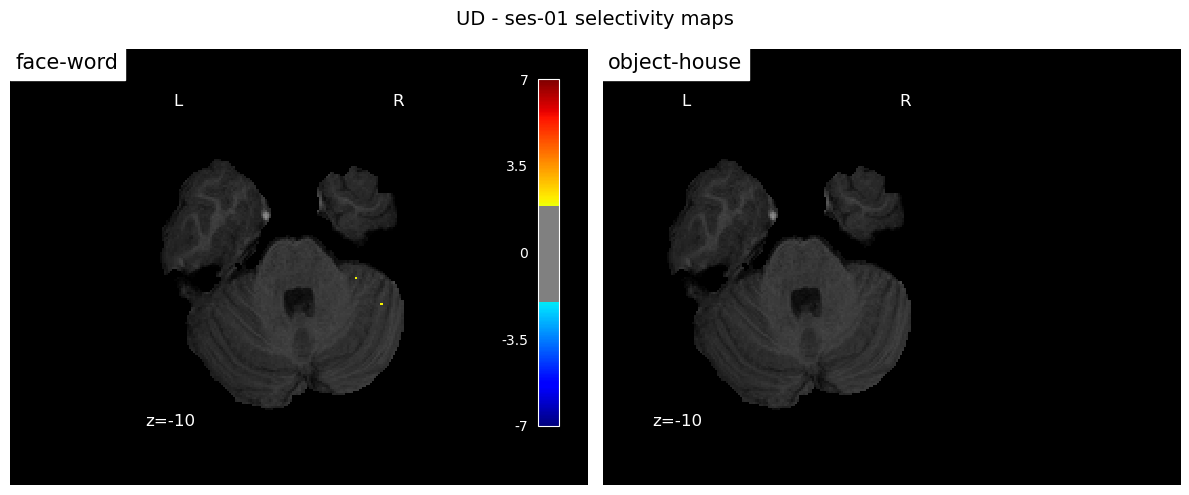

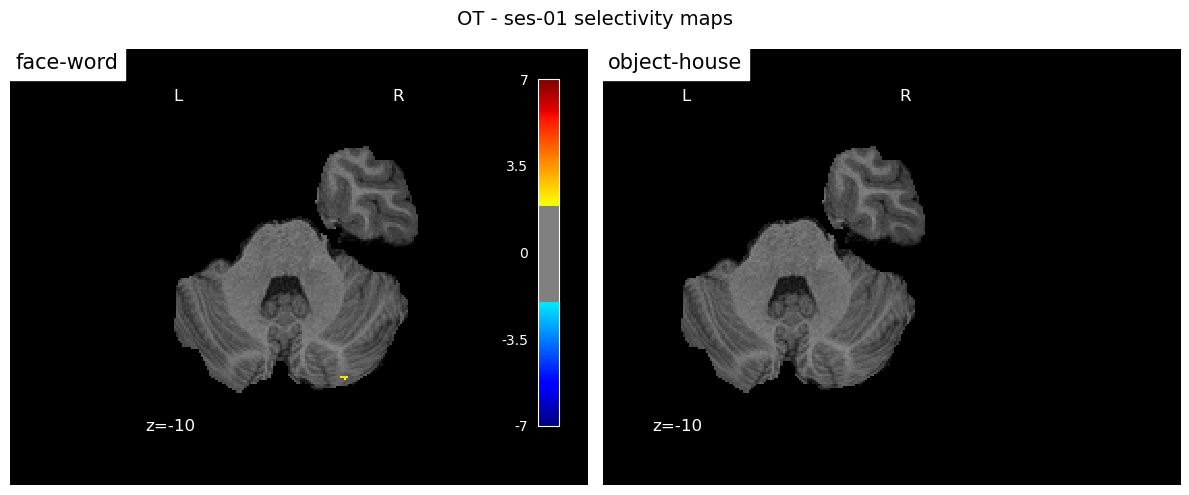

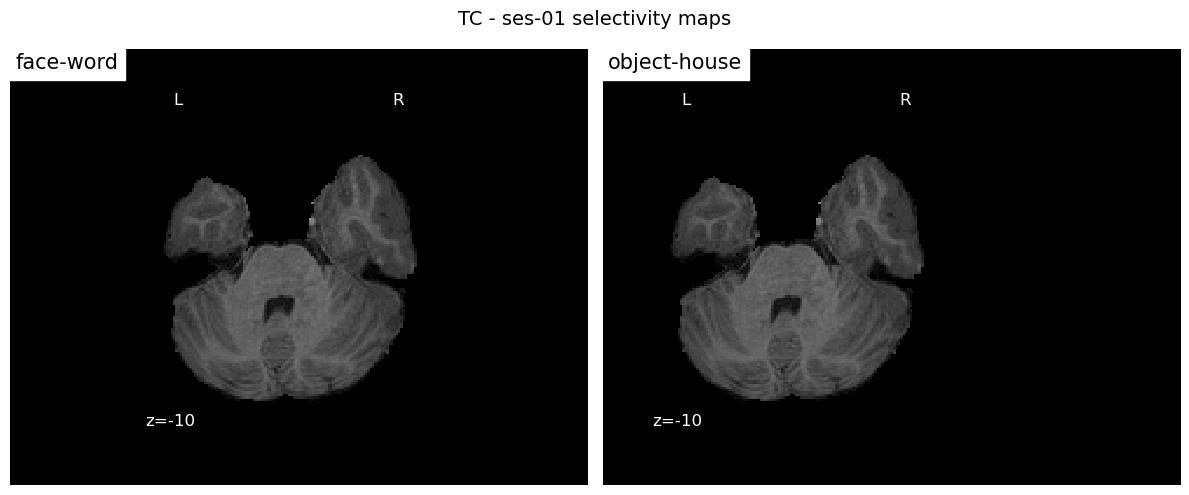

In [6]:
# STEP 5: Visualize spatial patterns in ses-01

for subject_id in SUBJECTS.keys():
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    anat_file = BASE_DIR / subject_id / 'ses-01' / 'anat' / f'{subject_id}_ses-01_T1w_brain.nii.gz'
    anat = nib.load(anat_file)
    
    for idx, contrast in enumerate(['face_word', 'object_house']):
        # Create selectivity map
        selectivity_map = np.zeros(anat.shape)
        
        if '01' in voxel_timeseries[subject_id][contrast]:
            values = voxel_timeseries[subject_id][contrast]['01']
            voxel_idx = votc_voxels[subject_id]['voxel_indices']
            selectivity_map[voxel_idx] = values
            
            selectivity_img = nib.Nifti1Image(selectivity_map, anat.affine)
            
            plotting.plot_stat_map(
                selectivity_img, bg_img=anat, axes=axes[idx],
                threshold=2.0, cmap='jet', vmax=7,
                display_mode='z', cut_coords=[-10],
                title=f'{contrast.replace("_", "-")}'
            )
    
    fig.suptitle(f'{SUBJECTS[subject_id]["code"]} - ses-01 selectivity maps', fontsize=14)
    plt.tight_layout()
    plt.savefig(BASE_DIR / 'analyses' / f'{subject_id}_selectivity_maps_ses01.png', dpi=150)
    plt.show()

In [7]:
# STEP 6: Test hypothesis - bilateral categories more stable?

print("\n" + "="*60)
print("SPATIAL STABILITY COMPARISON")
print("="*60)
print("\nHypothesis: Object/house (bilateral) shows less spatial shift")
print("           than face/word (unilateral) in reorganizing patients\n")

for subject_id in SUBJECTS.keys():
    print(f"{SUBJECTS[subject_id]['code']} ({subject_id}):")
    
    if 'face_word' in spatial_stability[subject_id] and 'object_house' in spatial_stability[subject_id]:
        fw_disp = [d['distance_mm'] for d in spatial_stability[subject_id]['face_word']]
        oh_disp = [d['distance_mm'] for d in spatial_stability[subject_id]['object_house']]
        
        print(f"  Face/word mean displacement: {np.mean(fw_disp):.2f} mm")
        print(f"  Object/house mean displacement: {np.mean(oh_disp):.2f} mm")
        print(f"  Difference: {np.mean(fw_disp) - np.mean(oh_disp):.2f} mm")
        print()


SPATIAL STABILITY COMPARISON

Hypothesis: Object/house (bilateral) shows less spatial shift
           than face/word (unilateral) in reorganizing patients

UD (sub-004):
  Face/word mean displacement: 13.36 mm
  Object/house mean displacement: 36.08 mm
  Difference: -22.72 mm

OT (sub-007):
  Face/word mean displacement: 19.31 mm
  Object/house mean displacement: 20.55 mm
  Difference: -1.24 mm

TC (sub-021):
  Face/word mean displacement: 11.29 mm
  Object/house mean displacement: 20.94 mm
  Difference: -9.65 mm



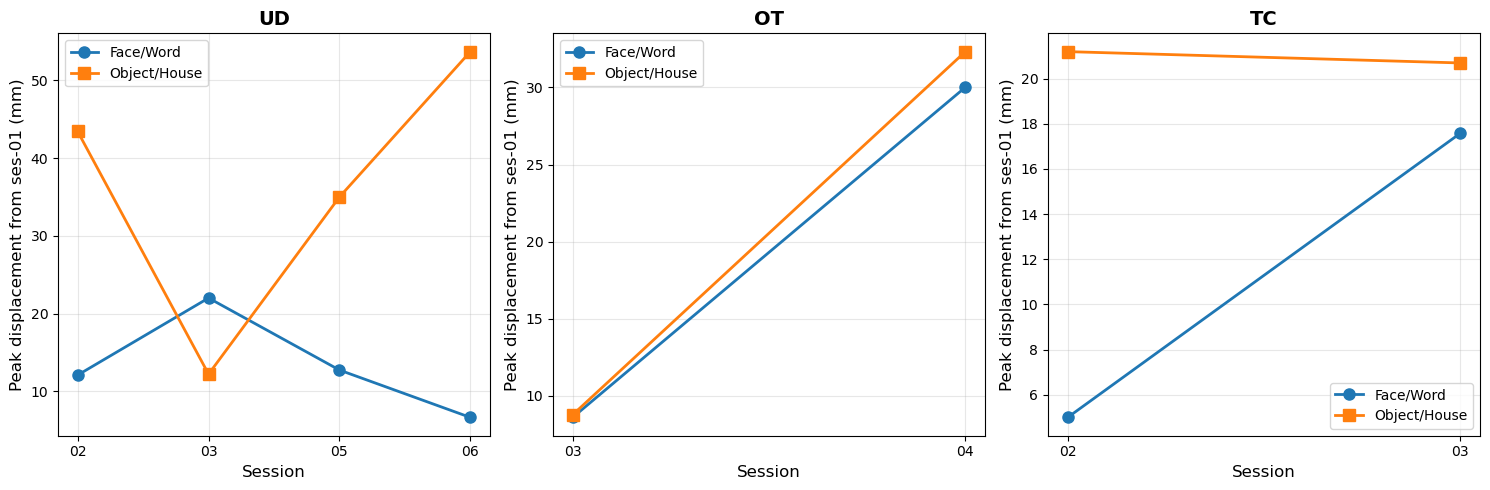

Analysis complete!


In [8]:
# STEP 7: Summary visualization

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, subject_id in enumerate(SUBJECTS.keys()):
    ax = axes[idx]
    
    if 'face_word' in spatial_stability[subject_id]:
        fw_sessions = [d['session'] for d in spatial_stability[subject_id]['face_word']]
        fw_dist = [d['distance_mm'] for d in spatial_stability[subject_id]['face_word']]
        ax.plot(fw_sessions, fw_dist, 'o-', label='Face/Word', linewidth=2, markersize=8)
    
    if 'object_house' in spatial_stability[subject_id]:
        oh_sessions = [d['session'] for d in spatial_stability[subject_id]['object_house']]
        oh_dist = [d['distance_mm'] for d in spatial_stability[subject_id]['object_house']]
        ax.plot(oh_sessions, oh_dist, 's-', label='Object/House', linewidth=2, markersize=8)
    
    ax.set_xlabel('Session', fontsize=12)
    ax.set_ylabel('Peak displacement from ses-01 (mm)', fontsize=12)
    ax.set_title(SUBJECTS[subject_id]['code'], fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(BASE_DIR / 'analyses' / 'spatial_stability_comparison.png', dpi=150)
plt.show()

print("Analysis complete!")